# Análise de Redes 1

## Programa para Cálculo do Fluxo de Potência usando o Método da Varredura

### Importa as Bibliotecas que serão utilizadas

In [1]:
from math import cos, sin
import numpy as np
import pprint
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Define a precisão a ser usada

In [2]:
%precision %.4f

'%.4f'

### Função que calcula o fluxo de potencia usando o metodo da varredura

In [3]:
def metodo_varredura(dbar, num_bar, dlin, num_lin, slack_bar, tol, num_max_iter):
    """
    Funcao que calcula o fluxo de potencia através do metodo da varredura
    
    :param dbar: (array) Array contendo os dados de barra
    :param num_bar: (int) Numero de barras
    :param dlin: (array) Array contendo os dados de barra
    :param num_lin: (int) Numero de linhas
    :param slack_bar: (int) Numero da barra de referencia
    :param tol: (float) Tolerancia para o processo de convergencia
    :param num_max_iter: (int) Numero maximo de iteracoes para o metodo 
                        parar caso nao atinja a convergencia
    :return: conexao, volt, corrente, erro
    """

    # Define variaveis
    convergiu = False
    cont_intermed = 0
    cont_final = 0
    found = 0

    # Contador das iteracoes
    __iter__ = 0

    # Matriz que define quais nos estao conectados
    conexao = np.zeros([num_bar, num_bar], dtype=np.complex)

    # Vetor com os nos intermediarios
    nos_intermed = [0]\

    # Vetor com os nos finais
    nos_finais = [0]

    # Procedimento para encontrar os nos intermediarios e finais e
    # gravar as conexoes para nos intermediarios
    for i in range(num_lin):
        for j in range(num_lin):
            if i != j and dlin[i, 1] == dlin[j, 0]:
                if cont_intermed == 0:
                    nos_intermed[-1] = int(dlin[i, 1])
                    cont_intermed = 1
                    found = 1
                    
                    conexao[int(dlin[i, 0])-1, int(dlin[i, 1])-1] = \
                        complex(dlin[i, 2], dlin[i, 3])
                    
                    break
                else:
                    nos_intermed.append(int(dlin[i, 1]))
                    found = 1
                    
                    conexao[int(dlin[i, 0])-1, int(dlin[i, 1])-1] = \
                        complex(dlin[i, 2], dlin[i, 3])
                    
                    break
            elif i != 0 and found == 0 and j == num_lin - 1:
                if cont_final == 0:
                    nos_finais[-1] = int(dlin[i, 1])
                    cont_final = 1
                else:
                    nos_finais.append(int(dlin[i, 1]))
        found = 0

    # print('Nos intermediarios: {}'.format(nos_intermed))
    # print('Nos finais: {}'.format(nos_finais))

    # Grava os dados para o nos finais
    for i in range(len(nos_finais)):
        for j in range(num_lin):
            if int(dlin[j, 1]) == nos_finais[i]:
                conexao[int(dlin[j, 0])-1, nos_finais[i] - 1] = \
                    complex(dlin[j, 2], dlin[j, 3])

    # Inicializa a Tensao do nos finais
    volt = np.zeros([num_bar], dtype=np.complex)
    for i in range(len(nos_finais)):
        volt[nos_finais[i]-1] = complex(1.0, 0.0)

    # print('Tensao inicial: {}'.format(volt))

    nos_intermed.sort()

    corrente = np.zeros([num_bar, num_bar], dtype=np.complex)
    erro = list()

    # Inicia o algoritmo da Varredura
    while not convergiu or __iter__ < num_max_iter:

        # Calculo das correntes para os ns finais
        for i in range(len(nos_finais)):
            no_fim = nos_finais[i] - 1
            
            for j in range(num_bar):
                if conexao[j, no_fim] != complex(0.0, 0.0):
                    conectado_de = j
            
            pot_complexa = \
                complex(dbar[nos_finais[i] - 1, 5], dbar[nos_finais[i] - 1, 6])
            
            corrente[conectado_de, nos_finais[i]-1] = \
                (pot_complexa / volt[nos_finais[i]-1]).conjugate()

        # Calculo das correntes para os nos intermediarios
        for l in range(len(nos_intermed), 0, -1):
            i = l - 1
            for j in range(num_bar):
                if conexao[nos_intermed[i]-1, j] != \
                    complex(0.0, 0.0) and nos_intermed[i] - 1 != j:
                    
                    volt[nos_intermed[i]-1] = \
                        + volt[j] \
                        + corrente[nos_intermed[i]-1, j] \
                        * conexao[nos_intermed[i]-1, j]
                    
                    for k in range(num_bar):
                        if conexao[k, nos_intermed[i]-1] != complex(0.0, 0.0) and k != nos_intermed[i]-1:
                            no_sup = k
                            break
                    
                    pot_complexa = \
                        complex(dbar[nos_intermed[i] - 1, 5], \
                                dbar[nos_intermed[i] - 1, 6])
                    
                    corrente[no_sup, nos_intermed[i] - 1] = \
                        (pot_complexa / volt[nos_intermed[i] - 1]).conjugate()
                    
                    for i1 in range(num_bar):
                        if conexao[nos_intermed[i]-1, i1] != complex(0.0, 0.0) and \
                            i1 != nos_intermed[i] - 1:
                            corrente[no_sup, nos_intermed[i] - 1] += corrente[nos_intermed[i]-1, i1]
                    
                    if no_sup == slack_bar:
                        volt[no_sup] = \
                            volt[nos_intermed[i]-1] + \
                            corrente[no_sup, nos_intermed[i] - 1] * \
                            conexao[no_sup, nos_intermed[i] - 1]

        # Verifica se convergiu
        erro.append(abs(volt[slack_bar]))

        if 1.0 - tol <= volt[slack_bar] <= 1.0 + tol:
            convergiu = True
            break

        volt[slack_bar] = complex(1.0, 0.0)
        for i in range(num_bar):
            for j in range(num_bar):
                if conexao[i, j] != complex(0.0, 0.0):
                    volt[j] = volt[i] - corrente[i, j] * conexao[i, j]

        __iter__ += 1

    return convergiu, __iter__, conexao, volt, corrente, erro


### Função que calcula fluxo de potência com método de Newton-Raphson

In [4]:
def newton_raphson(dbar, num_bus, dlin, num_lin, slack_bar, tol, num_max_iter):

    # Funcao para calculo do y_barra, dados nbus e dados_linha
    def calcula_ybarra(nbus, dados_linha):
        # Inicializa uma matriz, nbus x nbus, do tipo complexo
        y_barra = np.zeros([nbus, nbus], dtype=np.complex)

        # Percorre as linhas e calcula os elementos
        for lin in dados_linha:
            p = int(lin[0]) - 1
            q = int(lin[1]) - 1
            # Monta
            zkm = complex(lin[2], lin[3])
            bsh = complex(0, lin[4]/2.0)
            ykm = 1/zkm
            y_barra[p,p] += ykm + bsh
            if p != q:
                y_barra[q,q] += ykm + bsh
                y_barra[p,q] -= ykm
                y_barra[q,p] = y_barra[p,q]

        # Retorna a matriz y_barra
        return y_barra

    # Matriz de Admitancia Nodal
    y_barra = calcula_ybarra(num_bus, dlin)
    
    # Matriz condutancia nodal
    G = y_barra.real
    
    # Matriz susceptancia nodal
    B = y_barra.imag
    
    # Numero que representa infinito
    BIG_NUMBER = 1.0e10

    # Flag para barra de referencia
    flag_ref = [True if int(barra[1]) == 2 else False for barra in dbar]

    # Inicializa Potencia Definida
    pd = [barra[3] - barra[5] for barra in dbar]
    qd = [barra[4] - barra[6] for barra in dbar]

    # Inicializa Tensao
    vd = [barra[2]/1000.0 for barra in dbar]

    # Inicializa Theta
    td = [0.0] * num_bus

    # Inicializa delta_p e delta_q
    delta_p = np.zeros([num_bus, 1])
    delta_q = np.zeros([num_bus, 1])

    # Lista para guardar o erro maximo de cada iteracao
    err_list = list()

    # Contador de iteracoes
    _iter_ = 1
    
    # Controla convergencia
    convergiu = False

    while _iter_ <= num_max_iter:

        # Inicializa Potencia Ativa e Reativa Calculada
        p_calc = np.zeros([num_bus, 1])
        q_calc = np.zeros([num_bus, 1])

        # Prepara sistema de equacoes - elementos da diagonal
        for nbus in range(num_bus):
            p_calc[nbus, 0] = + vd[nbus] ** 2 * G[nbus, nbus]
            q_calc[nbus, 0] = - vd[nbus] ** 2 * B[nbus, nbus]

        # Prepara sistema
        for linha in dlin:
            k = int(linha[0])
            m = int(linha[1])
            tkm = td[k - 1] - td[m - 1]
            gkm = G[k - 1, m - 1]
            bkm = B[k - 1, m - 1]

            p_calc[k - 1, 0] += vd[k - 1] * vd[m - 1] * (gkm * cos(tkm) + bkm * sin(tkm))
            p_calc[m - 1, 0] += vd[m - 1] * vd[k - 1] * (gkm * cos(tkm) - bkm * sin(tkm))

            q_calc[k - 1, 0] += vd[k - 1] * vd[m - 1] * (gkm * sin(tkm) - bkm * cos(tkm))
            q_calc[m - 1, 0] += vd[m - 1] * vd[k - 1] * (-gkm * sin(tkm) - bkm * cos(tkm))

        # Calcula Delta P e Delta Q para cada barra
        # pd e pq devem ser calculado PG -PD = (PL)
        for nbus in range(num_bus):
            if flag_ref[nbus]:
                delta_p[nbus] = 0.0
                delta_q[nbus] = 0.0
            else:
                delta_p[nbus] = pd[nbus] - p_calc[nbus, 0]
                delta_q[nbus] = qd[nbus] - q_calc[nbus, 0]

        delta_y = np.vstack([delta_p, delta_q])
        err_list.append(np.max(delta_y))

        # Verifica se o algoritimo convergiu
        # Se todos os componentes de delta_y sao
        # menores que a tolerancia, entao convergiu
        if np.all(np.abs(delta_y) < tol):
            convergiu = True
            break

        # Se a convergencia nao foi atingida, entao
        # inicio a construcao da Jacobiana

        # Inicializa as submatrizes da Jacobiana
        h_jac = np.zeros([num_bus, num_bus])
        n_jac = np.zeros([num_bus, num_bus])
        m_jac = np.zeros([num_bus, num_bus])
        l_jac = np.zeros([num_bus, num_bus])

        # Calcula os elementos fora da diagonal
        for nlin, linha in enumerate(dlin):
            k = int(linha[0])
            m = int(linha[1])

            # Calcula diferenca angular
            tkm = td[k-1] - td[m-1]
            tmk = -tkm

            gkm = G[k - 1, m - 1]
            bkm = B[k - 1, m - 1]

            # Calcula as submatrizes H, M, N, L
            h_jac[k-1,m-1] += vd[k-1] * vd[m-1] * (gkm * sin(tkm) - bkm * cos(tkm))
            n_jac[k-1,m-1] += vd[k-1] * (gkm * cos(tkm) + bkm * sin(tkm))
            m_jac[k-1,m-1] -= vd[k-1] * vd[m-1] * (gkm * cos(tkm) + bkm * sin(tkm))
            l_jac[k-1,m-1] += vd[k-1] * (gkm * sin(tkm) - bkm * cos(tkm))

            h_jac[m-1,k-1] += vd[m-1] * vd[k-1] * (gkm * sin(tmk) - bkm * cos(tmk))
            n_jac[m-1,k-1] += vd[m-1] * (gkm * cos(tmk) + bkm * sin(tmk))
            m_jac[m-1,k-1] -= vd[m-1] * vd[k-1] * (gkm * cos(tmk) + bkm * sin(tmk))
            l_jac[m-1,k-1] += vd[m-1] * (gkm * sin(tmk) - bkm * cos(tmk))

        # Calcula matriz jacobiana, elementos da diagonal
        for nbus in range(num_bus):
            h_jac[nbus, nbus] = -(q_calc[nbus] + vd[nbus]**2 * B[nbus, nbus])
            n_jac[nbus, nbus] = 1.0 / vd[nbus] * (p_calc[nbus] + vd[nbus]**2 * G[nbus, nbus])
            m_jac[nbus, nbus] = p_calc[nbus] - vd[nbus]**2 * G[nbus, nbus]
            l_jac[nbus, nbus] = 1.0 / vd[nbus] * (q_calc[nbus] - vd[nbus]**2 * B[nbus, nbus])

            if dbar[nbus][1] == 2:
                h_jac[nbus, nbus] = BIG_NUMBER
                l_jac[nbus, nbus] = BIG_NUMBER

        # Monta a matriz Jacobiana
        JAC = np.vstack([np.hstack([h_jac, n_jac]), np.hstack([m_jac, l_jac])])

        # Calcula a inversa da Jacobiana
        INV_JAC = np.linalg.inv(JAC)

        # Resolve sistema de equacoes e calcula DeltaV e DeltaTheta
        delta_x = np.dot(INV_JAC, delta_y)

        # Atualiza Magnitude e Angula da Tensão
        td = td + delta_x[:num_bus,0]
        vd = vd + delta_x[num_bus:,0]
        
        _iter_ += 1    
        
    return convergiu, _iter_, td, vd, err_list

### Cria os dados de Barra

In [5]:
def define_dados_barra():
    # Dados de Barra
    dabrt= ['NUM', 'TIPO', 'VOLT', 'PGER', 'QGER', 'PLOAD', 'QLOAD', 'SHUNT']
    dbar = np.array(
        [[  1 ,     2 ,  1000 ,   0.0 ,   0.0 ,    1.0 ,    1.0 ,    0.0 ],
         [  2 ,     0 ,  1000 ,   0.0 ,   0.0 , 0.0510 , 0.0200 ,    0.0 ],
         [  3 ,     0 ,  1000 ,   0.0 ,   0.0 , 0.1920 , 0.0765 ,    0.0 ],
         [  4 ,     0 ,  1000 ,   0.0 ,   0.0 , 0.0495 , 0.0194 ,    0.0 ]])
    num_bar = dbar.shape[0]
    return dbar, num_bar

### Cria os dados de Linha

In [6]:
def define_dados_linha():
    # Dados de Linha
    dlint= ['DE', 'PARA',     'R',     'X', 'MVAR', 'TAP']
    dlin = np.array(
        [[ 1 ,     2 , 0.2360 , 0.6750 ,   0.0 ,  0.0 ],
         [ 2 ,     3 , 0.0778 , 0.2133 ,   0.0 ,  0.0 ],
         [ 2 ,     4 , 0.3060 , 0.7320 ,   0.0 ,  0.0 ]])
    num_lin = dlin.shape[0]
    return dlin, num_lin

### Método para rodar o método de Varredura

In [7]:
def roda_varredura(tol):
    # Barra de Referencia
    slack_bar = 0

    # numero maximo de iteracoes
    num_max_iter = 30

    # Cria as variáveis de dados de barra
    dbar, num_bar = define_dados_barra()

    # Cria as variáveis de dados de linha
    dlin, num_lin = define_dados_linha()

    # Chama método de Newton-Raphson
    convergiu_nr, __iter__nr, theta_nr, volt_nr, erro_nr = \
        newton_raphson(dbar, num_bar, dlin, num_lin, slack_bar, tol, num_max_iter)

    # Calcula Tensao Real e Imaginaria
    volt = np.zeros_like(volt_nr, dtype=np.complex)
    for i in range(num_bar):
        volt[i] = volt_nr[i] * complex(cos(theta_nr[i]), sin(theta_nr[i]))

    # Chama a funcao para calcula do fluxo de potencia
    convergiu_vr, __iter__vr, conexao, volt_vr, corrente, erro_vr = \
        metodo_varredura(dbar, num_bar, dlin, num_lin, slack_bar, tol, num_max_iter)
        
    if convergiu_vr and convergiu_nr:

        print('Método da Varredura convergiu em {} iteracaoes!'.format(__iter__vr+1))
        print('Método de Newton convergiu em {} iteracaoes!'.format(__iter__nr+1))
        print()
        print('------------------------------------------')
        print('BARRA      TENSAO VR        TENSAO NR     ')
        print('        REAL     IMAG     REAL     IMAG   ')
        print('------------------------------------------')

        for i in range(num_bar):
            print('{:>4}   {:7.4f}  {:7.4f}  {:7.4f}  {:7.4f}'.format(i + 1, \
                                                                      volt_vr[i].real, \
                                                                      volt_vr[i].imag, \
                                                                      volt[i].real, \
                                                                      volt[i].imag))

        x_vr = np.arange(len(erro_vr))
        x_nr = np.arange(len(erro_nr))

        label_vr = x_vr
        label_nr = x_nr

        plt.subplots(2,1)
        plt.title('Convergencia do Fluxo de Potencia')
        
        plt.subplot(2,1,1)
        plt.plot(x_vr, erro_vr)
        plt.ylabel('Erro (p.u.)')
        plt.xlabel('Iteracoes Metodo Varredura')
        plt.tight_layout()


        plt.subplot(2,1,2)
        plt.plot(x_nr, erro_nr)
        plt.ylabel('Erro (p.u.)')
        plt.xlabel('Iteracoes Metodo Newton')
        plt.tight_layout()


        plt.show()

    else:

        print('Processo não convergiu!')

    

### Chama o metodo para rodar o método de Varredura

Método da Varredura convergiu em 29 iteracaoes!
Método de Newton convergiu em 7 iteracaoes!

------------------------------------------
BARRA      TENSAO VR        TENSAO NR     
        REAL     IMAG     REAL     IMAG   
------------------------------------------
   1    1.0000   0.0000   1.0000  -0.0000
   2    0.7385  -0.1705   0.7385  -0.1705
   3    0.6824  -0.2049   0.6824  -0.2049
   4    0.6874  -0.1997   0.6874  -0.1997


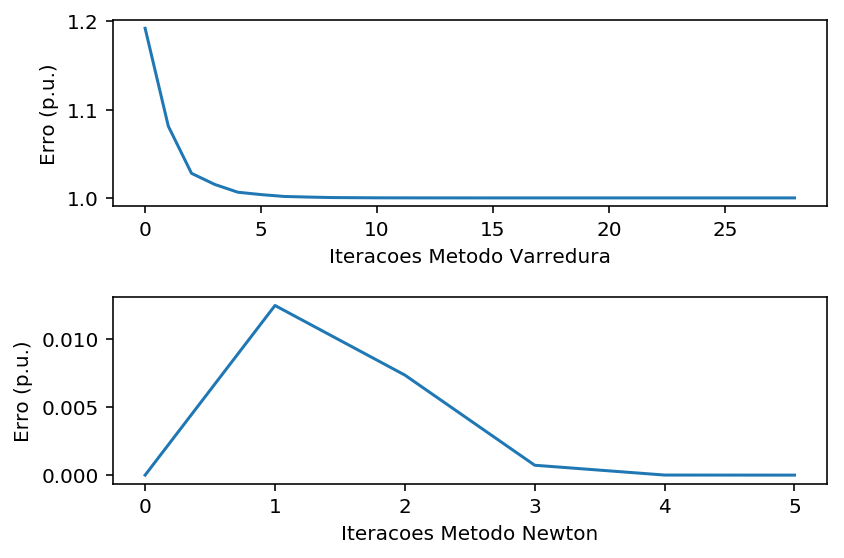

Método da Varredura convergiu em 15 iteracaoes!
Método de Newton convergiu em 6 iteracaoes!

------------------------------------------
BARRA      TENSAO VR        TENSAO NR     
        REAL     IMAG     REAL     IMAG   
------------------------------------------
   1    1.0000   0.0000   1.0000  -0.0000
   2    0.7385  -0.1704   0.7385  -0.1705
   3    0.6824  -0.2049   0.6824  -0.2049
   4    0.6874  -0.1997   0.6874  -0.1997


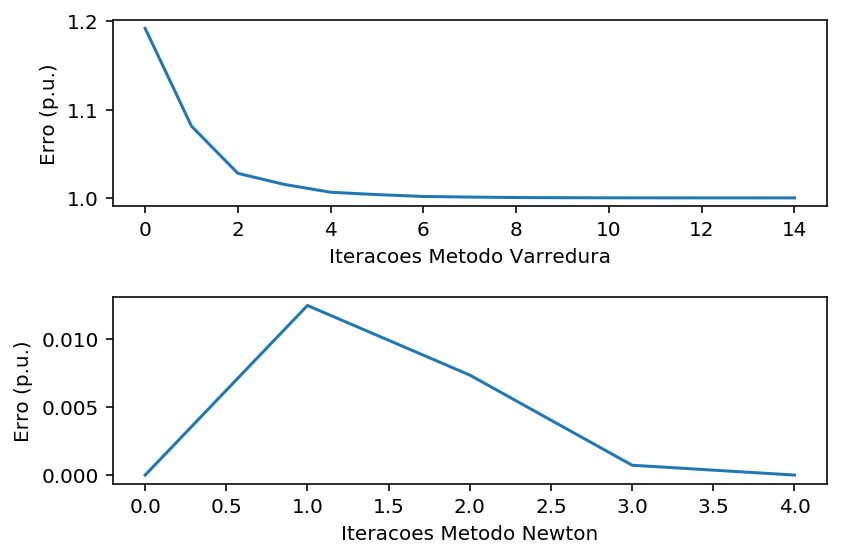

In [8]:
if __name__ == '__main__':
    tol = 1.0e-9
    roda_varredura(tol)

    tol = 1.0e-5
    roda_varredura(tol)

> O **Método da Varredura** convergiu em 28 iterações, considerando uma tolerância de 1.0e-9. **Newton-Raphson** convergiu em 5 iterações. 
<p> Se passarmos a tolerância para 1.0e-5, **Newton-Raphson** converge em 4 iterações e o **Método da Varredura** converge em 14 iterações.